In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file
from utils.cast_data import apply_datetime_format
from src.src import *

In [4]:
# ToDos

# ff_HML stationary?

# need to force normal distribution?

# test features for heteroskedasticity against time?

# resolve multicolinerarity -> orthogonolisation
#     start off with highest correlation variables
    
# Regression
#     select variables

In [5]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

('nan format unknonw',)
('nan format unknonw',)
Unknown columns found
['date', 'date_week']


In [6]:
# select relevant data
df_w = df_all.drop(data_dict["data_cols"]["fears"], axis=1)
df_w = cut_to_weekly_data(df_w).reset_index(drop=True).copy()
df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name=["sp_close_lag1", "sp_close_lag2", "sp_close_lag3"], no_lags=[-1, -2, -3])

In [7]:
# edit data_dict
data_dict.update(predicted="sp_close_lag1")
data_dict.update(sp_cols=["sp_close", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3"])


relevant_cols=[
    # 'fears35',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish'
] 
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [8]:
# log transform
trans = DataTransformation(df_w,
                           data_dict)
trans.df_transform(data_dict["relevant_cols"] + data_dict["sp_cols"], transformation="log_return")

df_w = trans.df
data_dict = trans.dict_
df_w.dropna(inplace=True)

In [9]:
# stationarity
stest = StatsTest(plot=False)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

stationarity

{'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True}

# correlation

In [12]:
cols = [
    'vixo',
    # 'fears35',
     'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     'pc_ratio',
     'aaii_Bullish',
    'ff_HML',
    'sp_close_lag2',
    'sp_close_lag3'
    
]

In [13]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [14]:
data_dict["lag_correl"] = lag_correl(df_w,
                                     cols,
                                     col_predicted="sp_close_lag1",
                                     plot_fig=False)
data_dict["lag_correl"]

[['vixo', -1],
 ['naaim_ind', -1],
 ['ff_M_RF', -1],
 ['ff_SMB', -1],
 ['ff_RMW', -1],
 ['ff_CMA', -1],
 ['termspread', -1],
 ['pc_ratio', -1],
 ['aaii_Bullish', -1],
 ['ff_HML', -1],
 ['sp_close_lag2', -1],
 ['sp_close_lag3', -1]]

# Multicolinerarity

In [15]:
get_variance_inflation_factor(df_ws,
                              cols,
                             col_pred=data_dict["predicted"])

,VIF,corr_sp_close_lag1
sp_close_lag2,978.533748,-0.567399
ff_M_RF,63.225504,-0.408806
aaii_Bullish,66.715891,-0.242055
ff_SMB,32.477136,-0.175653
ff_HML,59.808323,-0.157423
naaim_ind,16.957683,-0.128573
sp_close_lag3,981.723916,0.079515
termspread,110.930109,0.083855
ff_CMA,70.889991,0.179533
ff_RMW,58.583375,0.181984


In [29]:
corr_matrix = df_ws[cols].corr()
mask = np.triu(corr_matrix)

fig = plt.figure(figsize=(.75 * len(corr_matrix), .75 * len(corr_matrix)))
sns.heatmap(abs(corr_matrix),
            annot=True,
            cmap="Blues",
            vmin=0,
            vmax=.5,
           mask=mask,
           cbar=False)
plt.tight_layout()
plt.close(fig)

# Regression 2

In [30]:
import statsmodels.api as sm

In [31]:
df_train = df_ws.copy()
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False)

In [32]:
model = sm.OLS(y_train, X_train, random_state=random_state).fit()

In [33]:
model.pvalues < 0.05

vixo              True
naaim_ind         True
ff_M_RF           True
ff_SMB           False
ff_RMW            True
ff_CMA           False
termspread       False
pc_ratio         False
aaii_Bullish      True
ff_HML           False
sp_close_lag2     True
sp_close_lag3     True
intercept         True
dtype: bool

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sp_close_lag1   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     96.02
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          9.24e-118
Time:                        19:00:00   Log-Likelihood:                 1616.2
No. Observations:                 480   AIC:                            -3206.
Df Residuals:                     467   BIC:                            -3152.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo              0.0801      0.006     12.894      0.000       0.068       0.092
naaim_ind        -0.0037      0.002     -1.969      0.049      -0.007   -8.22e-06
ff_M_RF          -0.0285      0.004     -7.015      0.000      -0.036      -0.020
ff_SMB           -0.0043      0.003     -1.423      0.156      -0.010       0.002
ff_RMW            0.0089      0.004      2.097      0.037       0.001       0.017
ff_CMA            0.0041      0.005      0.842      0.400      -0.005       0.014
termspread        0.0048      0.006      0.808      0.419      -0.007       0.016
pc_ratio          0.0037      0.004      0.841      0.401      -0.005       0.012
aaii_Bullish     -0.0115      0.005     -2.540      0.011      -0.020      -0.003
ff_HML            0.0040      0.004      0.942      0.347      -0.004       0.012
sp_close_lag2    -0.7085      0.031    -22.838      0.000      -0.769      -0.648
sp_close_lag3    -0.3556      0.031    -11.480      0.000      -0.416      -0.295
intercept         1.3912      0.040     34.985      0.000       1.313       1.469
==============================================================================
Omnibus:                       87.912   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.616
Skew:                           0.570   Prob(JB):                    7.70e-135
Kurtosis:                       8.439   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Prediction

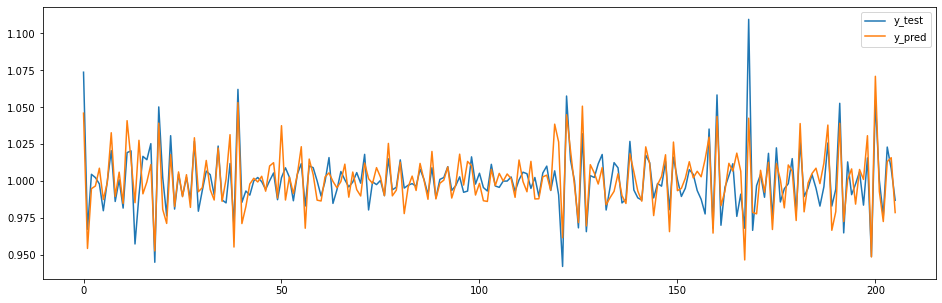

Validation Scores
mean squared error: 0.00016266
mean absolute error: 0.00934606
R2: 0.6034


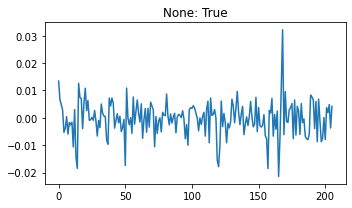

Stationarity Test Results
P-Values: 2.5053706988683433e-25
Test-stats: -13.541756215512756
Time series is stationary: True


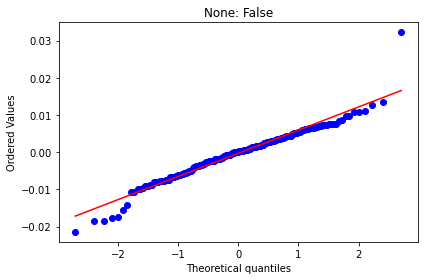

Normality Test Results
P-Values: 1.2551896179671492e-05
Test-stats: 22.571277627571526
Series is normally distributed: False


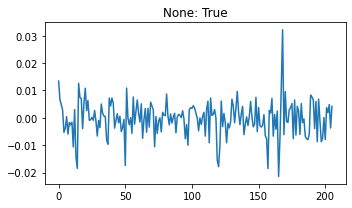

Test for Heteroskedasticity
Test p-value: 0.00015692448228106945
Heteroskedasticity is present: True


In [35]:
mval = ModelValidation(X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

In [36]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), 
                       rand_jitter(y),
                       s=s,
                       c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)